# Consecutive dry days

In [1]:
import os
import os.path as op
import sys
import folium

import numpy as np
import pandas as pd

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs

sys.path.append("../../../functions")
from data_downloaders import GHCN

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [3]:
update_data = False
path_data = "../../../data"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

## Using Koror Station

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

In [6]:
dict_prcp = [{'data' : data, 'var' : 'PRCP', 'ax' : 1, 'label' : 'Precipitation'},]
fig = plot_timeseries_interactive(dict_prcp, trendline=True, ylims = [None, None], figsize = (25, 12))

In [7]:
threshold = 1 #Threshold for dry and wet day
data = dict_prcp[0]['data']#.dropna()
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()
data['dry_day'] = np.where(data['PRCP'] < threshold, 1, 0)

In [8]:
def consecutive_dry_days(series):
    consec_dry = 0
    max_consec_dry = 0
    for value in series:
        if value:  # If it's a dry day (True)
            consec_dry += 1
        else:  # If it's not a dry day (False)
            max_consec_dry = max(max_consec_dry, consec_dry)
            consec_dry = 0
    return max_consec_dry

In [9]:
consecutive_dry_year = data.groupby(data.index.year)['dry_day'].apply(consecutive_dry_days)

In [10]:
threshold = 1
data['below_threshold'] = data['PRCP'] < threshold

# Función para calcular días consecutivos por debajo del umbral
def count_consecutive_days(series):
    count = 0
    result = []
    for value in series:
        if value:
            count += 1
        else:
            count = 0
        result.append(count)
    return result

# Aplica la función
data['consecutive_days'] = count_consecutive_days(data['below_threshold'])

<Axes: ylabel='Mean consecutive dry days [< 1mm]'>

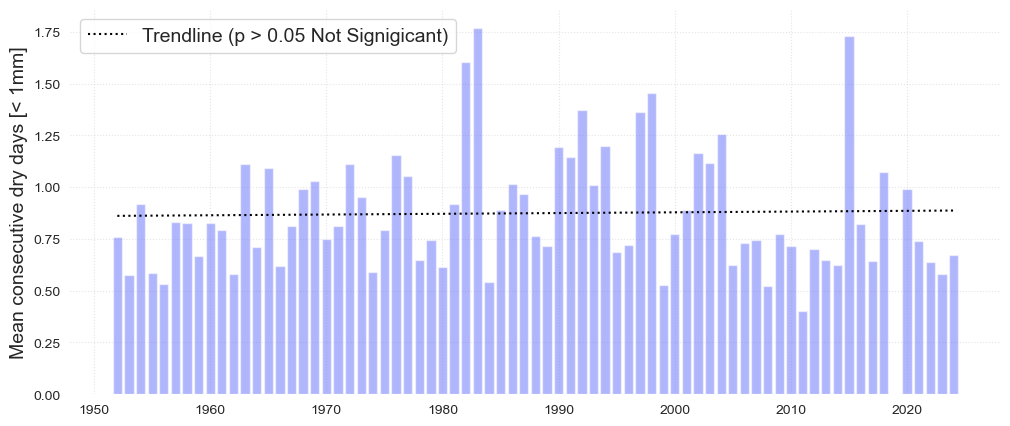

In [11]:
plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].mean(), 
               trendline =True, y_label = 'Mean consecutive dry days [< 1mm]',
               figsize = [12, 5])


<Axes: ylabel='Maximum consecutive dry days [< 1mm]'>

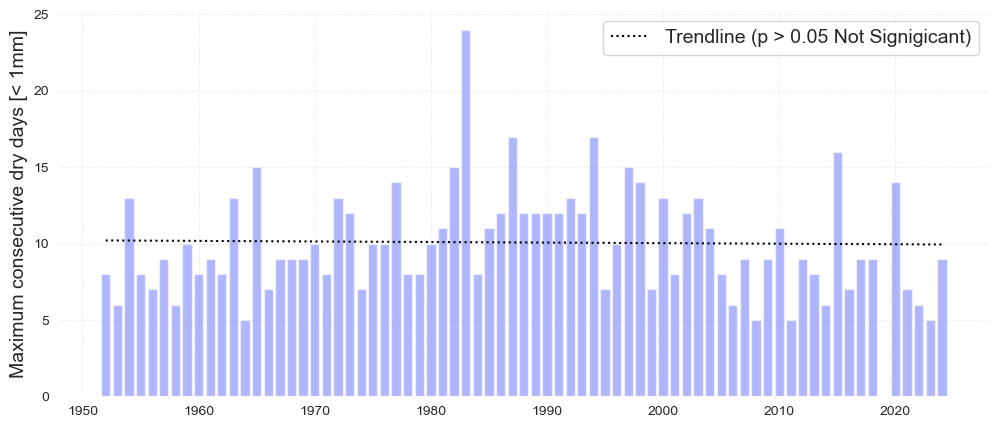

In [12]:
plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].max(), 
               trendline =True, y_label = 'Maximum consecutive dry days [< 1mm]',
               figsize = [12, 5])

In [16]:
datag = data.groupby(data.index.year).max()
datag.index = pd.to_datetime(datag.index, format = '%Y')
dict_plot = [{'data' : datag, 'var' : 'consecutive_days', 'ax' : 1, 'label':'Max. number of consecutive dry days [< 1mm]'},]


In [24]:
# Drop missing values for the specified variable
data = datag['consecutive_days'].dropna()

# Convert the time index to numerical values for fitting
time = data.index.values
time_num = time.view('int64') // 1e9  # Convert to seconds since epoch (numeric format)

# Fit a linear trendline (degree 1 polynomial)
coefficients = np.polyfit(time_num, data.values, 1)  # Linear fit
trendline = np.poly1d(coefficients)  # Create a polynomial function for the trendline

In [32]:
from scipy.stats import linregress
a, b, c, p_value, _ = linregress(time_num, data.values)

In [17]:
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12));